In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.tree import plot_tree
import warnings

warnings.filterwarnings('ignore')



## Data Preprocessing

### Data Cleaning

In [43]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

In [44]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


In [45]:
# target variable is presence of heart disease in the patient - 0 (no presence) to 4. 
y.head()

,num
0,0
1,2
2,1
3,0
4,0


In [46]:
#Merge the data frames
if len(y) == len(X):
    dat = X.join(y, how='outer')
    
dat.head()
dat = dat.dropna(axis=0)

In [47]:
#Check for missing values and remove those rows
print(len(dat))

dat = dat.dropna(axis = 0)

print(len(dat))
#We dropped 6 rows that have missing values

297
297


### Feature Engingeering

In [48]:
#Binning Age: Divide age into predefined categories
dat['age_group'] = pd.cut(dat['age'], bins=[0, 30, 45, 60, 75, 100],
                         labels=['<30', '30-45', '45-60', '60-75', '>75'])


In [49]:
#Hypertension Flag
dat['hypertension'] = (dat['trestbps'] >= 140).astype(int)


In [50]:
#Cholesterol Risk
dat['cholesterol_risk'] = pd.cut(dat['chol'],
                                bins=[0, 200, 239, np.inf],
                                labels=['Desirable', 'Borderline high', 'High'])


In [51]:
#Interaction Terms
dat['age_cholesterol'] = dat['age'] * dat['chol']

### Rename columns

In [52]:
dat = dat.rename(columns={"thalach": "max_heart_rate", "oldpeak": "depression", "num": "heart_disease_diagnosis",
                   'exang': "exercise_induced_angina", "fbs": 'fasting_blood_sugar', 'ca': 'num_major_vessels',
                   'cp': 'chest_pain_type'})
dat.head()

,age,sex,chest_pain_type,trestbps,chol,fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,depression,slope,num_major_vessels,thal,heart_disease_diagnosis,age_group,hypertension,cholesterol_risk,age_cholesterol
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,60-75,1,Borderline high,14679
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,60-75,1,High,19162
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,60-75,0,Borderline high,15343
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,30-45,0,High,9250
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,30-45,0,Borderline high,8364


## Exploratory Data Analysis

### Visual Analysis

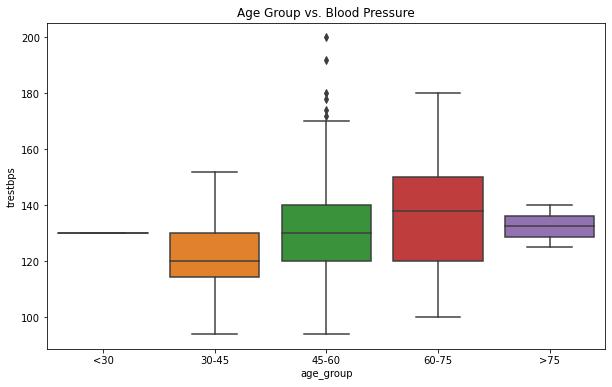

In [53]:
# Age Group vs. Systolic Blood Pressure
plt.figure(figsize=(10, 6))
sns.boxplot(x='age_group', y='trestbps', data=dat)
plt.title('Age Group vs. Blood Pressure')
plt.show()

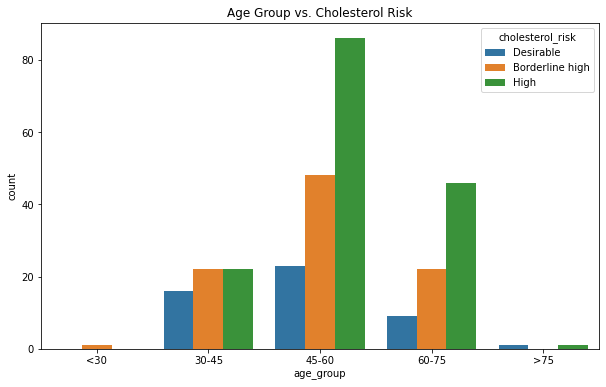

In [54]:
# Age Group vs. Cholesterol Risk
plt.figure(figsize=(10, 6))
sns.countplot(x='age_group', hue='cholesterol_risk', data=dat)
plt.title('Age Group vs. Cholesterol Risk')
plt.show()

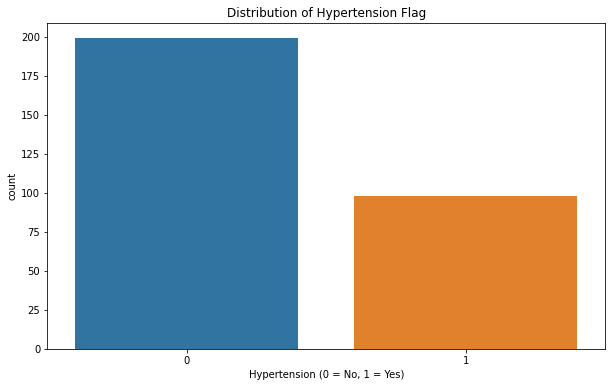

In [55]:
# Hypertension Flag Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='hypertension', data=dat)
plt.title('Distribution of Hypertension Flag')
plt.xlabel('Hypertension (0 = No, 1 = Yes)')
plt.show()


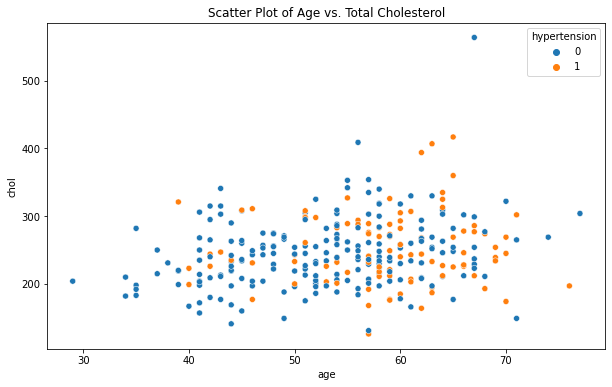

In [56]:
# Scatter Plot of Age and Cholesterol
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='chol', hue='hypertension', data=dat)
plt.title('Scatter Plot of Age vs. Total Cholesterol')
plt.show()

### Descriptive Statistics

In [57]:
# Descriptive Statistics
print("Descriptive Statistics:")
print(dat[['age', 'trestbps', 'chol', 'heart_disease_diagnosis']].describe())

# Correlation Matrix
print("\nCorrelation Matrix:")
print(dat[['age', 'trestbps', 'chol', 'heart_disease_diagnosis']].corr())


Descriptive Statistics:
              age    trestbps        chol  heart_disease_diagnosis
count  297.000000  297.000000  297.000000               297.000000
mean    54.542088  131.693603  247.350168                 0.946128
std      9.049736   17.762806   51.997583                 1.234551
min     29.000000   94.000000  126.000000                 0.000000
25%     48.000000  120.000000  211.000000                 0.000000
50%     56.000000  130.000000  243.000000                 0.000000
75%     61.000000  140.000000  276.000000                 2.000000
max     77.000000  200.000000  564.000000                 4.000000

Correlation Matrix:
                              age  trestbps      chol  heart_disease_diagnosis
age                      1.000000  0.290476  0.202644                 0.222156
trestbps                 0.290476  1.000000  0.131536                 0.159620
chol                     0.202644  0.131536  1.000000                 0.066448
heart_disease_diagnosis  0.222156  0

## Model Building

In [62]:
X = dat.drop(['heart_disease_diagnosis', 'age_group', 'cholesterol_risk'], axis=1)
y = dat['heart_disease_diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)


# Ensure y_train is properly formatted as a Series
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]  # Assuming y_train should be a single column from a DataFrame

# Calculate mode and handle potentially empty results
mode_value = y_train.mode()
if mode_value.empty:
    print("Mode computation returned an empty result. No mode to fill NaN values.")
else:
    # Fill NaN values with the first mode found
    y_train.fillna(mode_value.iloc[0], inplace=True)

if X_train.isnull().any().any():
    X_train = X_train.fillna(X_train.mean())

# Check for infinite values
if np.isinf(X_train.values).any():
    X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_train = X_train.fillna(X_train.mean())

### Random Forest Classifier

In [63]:
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test)
 
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL:", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL: 0.6444444444444445


### Decision Tree Classifier

In [72]:
clf = DecisionTreeClassifier(random_state=1)
param_grid = {
    'max_depth': range(1, 10, 1),
    'min_samples_leaf': range(1, 20, 2),
    'min_samples_split': range(2, 20, 2),
    'criterion': ["entropy", "gini"]
}

clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

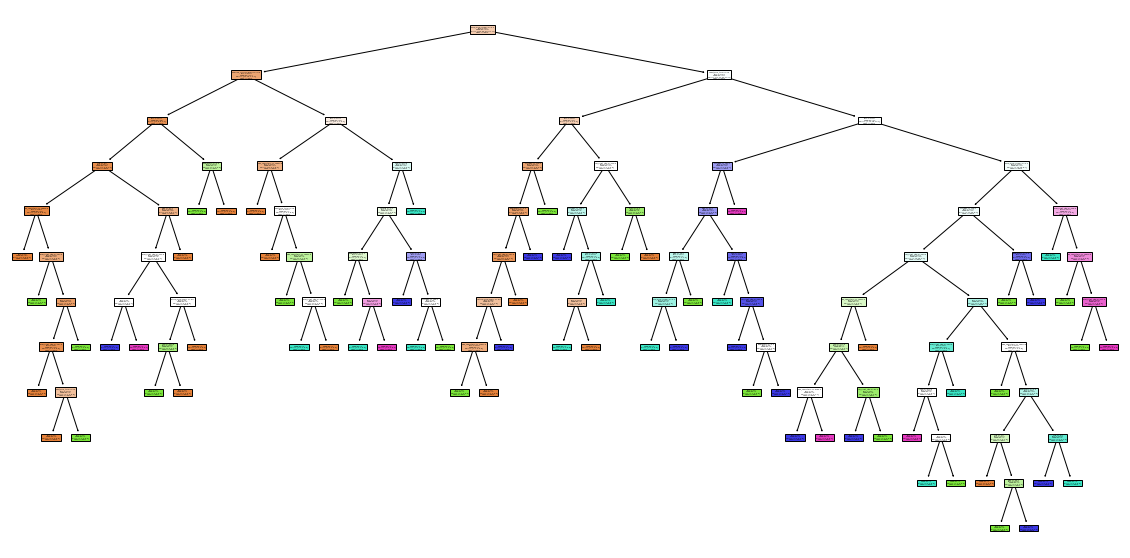

In [73]:
feature_names = X_train.columns.tolist()  # Ensure these are the names of the features
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']  # Adjust as necessary

plt.figure(figsize=(20,10))  # Adjust the size as needed
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()

## Feature Selection

### Decision Tree Classifier

                    Feature  Importance
11        num_major_vessels    0.170948
9                depression    0.140951
7            max_heart_rate    0.133031
4                      chol    0.097357
14          age_cholesterol    0.093508
0                       age    0.072665
3                  trestbps    0.064421
8   exercise_induced_angina    0.060656
2           chest_pain_type    0.060292
10                    slope    0.045090
12                     thal    0.029859
5       fasting_blood_sugar    0.020174
6                   restecg    0.011048
1                       sex    0.000000
13             hypertension    0.000000


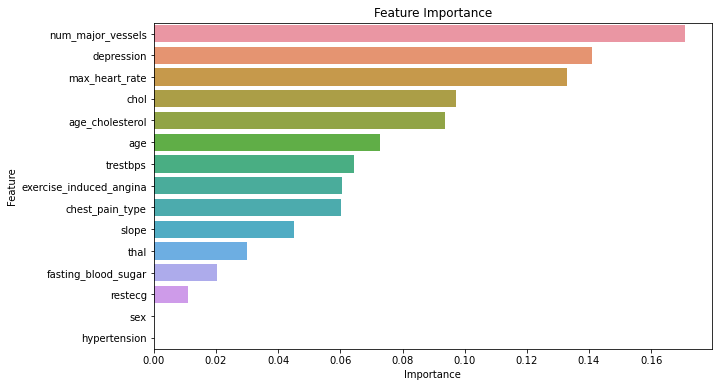

In [74]:
# Get feature importances
importances = clf.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

# Visualize feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()


In [75]:
top_features = feature_importance_df['Feature'].head(4)  # Select top 4 features

# Subset the training and testing data to include only the top 4 features
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]


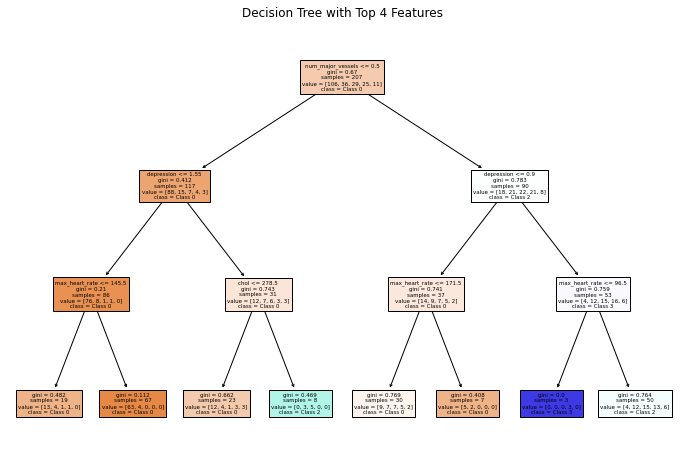

In [77]:
# Ensure top_features is converted to a list explicitly if it's not already
top_features_list = top_features.tolist()

# Initialize and fit the Decision Tree Classifier
clf_top_features = DecisionTreeClassifier(max_depth=3, random_state=1)
clf_top_features.fit(X_train_top, y_train)

# Plot the decision tree with the correct list of feature names
plt.figure(figsize=(12,8))  # Adjust the size as needed
plot_tree(clf_top_features, filled=True, feature_names=top_features_list, class_names=class_names)
plt.title('Decision Tree with Top 4 Features')
plt.show()


In [78]:
# Make predictions
y_pred_top = clf_top_features.predict(X_test_top)

# Calculate accuracy
accuracy_top = accuracy_score(y_test, y_pred_top)
print("Accuracy of the model with top 4 features:", accuracy_top)

# Additional detailed classification report
print(classification_report(y_test, y_pred_top))

Accuracy of the model with top 4 features: 0.6111111111111112
              precision    recall  f1-score   support

           0       0.70      0.93      0.80        54
           1       0.00      0.00      0.00        18
           2       0.28      0.83      0.42         6
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         2

    accuracy                           0.61        90
   macro avg       0.20      0.35      0.24        90
weighted avg       0.44      0.61      0.51        90



### Random Forest Classifier

In [80]:
# Initialize the Random Forest Classifier
rfc_top_features = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_top_features.fit(X_train_top, y_train)

# Make predictions on the test data
y_pred_rf = rfc_top_features.predict(X_test_top)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy of the Random Forest model with top 4 features:", accuracy_rf)

# Detailed classification report
print(classification_report(y_test, y_pred_rf))


Accuracy of the Random Forest model with top 4 features: 0.5333333333333333
              precision    recall  f1-score   support

           0       0.68      0.76      0.72        54
           1       0.18      0.11      0.14        18
           2       0.20      0.33      0.25         6
           3       0.43      0.30      0.35        10
           4       0.00      0.00      0.00         2

    accuracy                           0.53        90
   macro avg       0.30      0.30      0.29        90
weighted avg       0.51      0.53      0.52        90



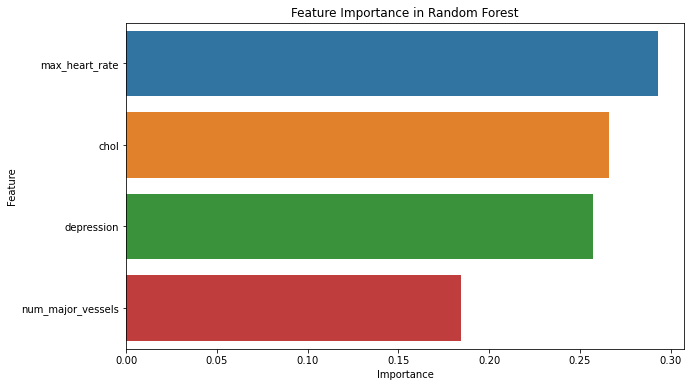

In [81]:
# Get feature importances
importances_rf = rfc_top_features.feature_importances_

# Create a DataFrame for easier visualization
importances_df_rf = pd.DataFrame({
    'Feature': top_features_list,
    'Importance': importances_rf
})
importances_df_rf = importances_df_rf.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df_rf)
plt.title('Feature Importance in Random Forest')
plt.show()


### Gradient Boosting Classifier

In [82]:
# Initialize Gradient Boosting Classifier
gbc_top_features = GradientBoostingClassifier(n_estimators=100, random_state=1)
gbc_top_features.fit(X_train_top, y_train)

GradientBoostingClassifier(random_state=1)

## Ensemble Learning Implementation

### Voting Classifier